__Lab 04 - SCA (Part 1): Statistical Analysis__

Student Names: [Jwala Sri Hari Badam & Ganesh Veluru]

Group Number: [3]

# Setup

## Importing Python Libraries & Setup ChipWhisperer

Begin by importing the required libraries, connecting to the scope, and applying the default setup:

In [271]:
%matplotlib notebook
import matplotlib.pyplot as plt
import chipwhisperer as cw
import numpy as np
import scipy.stats
from scipy import signal
from tqdm import tnrange
import random

Next, compile the firmware:

In [272]:
# This is an API for your CW's scope (in the CAPTURE section)
scope = cw.scope()

# This is an API for your CW's target (in the TARGET section)
target = cw.target(scope, cw.targets.SimpleSerial)

# Sets the scope's default settings
scope.default_setup()

# Cap the max num of power trace samples to collect
scope.adc.samples = 500

# Prints the scope settings
print(scope)

See https://chipwhisperer.readthedocs.io/en/latest/api.html#firmware-update


Serial baud rate = 38400
ChipWhisperer Nano Device
fw_version = 
    major = 0
    minor = 24
    debug = 0
io = 
    tio1         = None
    tio2         = None
    tio3         = None
    tio4         = None
    pdid         = True
    pdic         = False
    nrst         = True
    clkout       = 7500000.0
    cdc_settings = None
adc = 
    clk_src  = int
    clk_freq = 7500000.0
    samples  = 500
glitch = 
    repeat     = 0
    ext_offset = 0



Program the microcontroller with the "tvla-test-CWNANO" hex file:

In [273]:
%%bash
cd ../Firmware/
make PLATFORM=CWNANO CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
make clean_objs .dep 
make[1]: Entering directory '/home/phs/Desktop/phs-labs/PHS-Lab-04/Firmware'
SS_VER set to SS_VER_1_1

+--------------------------------------------------------

Removing old files
rm -f -- tvla-test-CWNANO.hex
rm -f -- tvla-test-CWNANO.elf
rm -f -- tvla-test-CWNANO.map
rm -f -- objdir-CWNANO/*.o
rm -f -- objdir-CWNANO/*.lst
rm -f -- tvla-test.s simpleserial.s stm32f0_hal_nano.s stm32f0_hal_lowlevel.s
rm -f -- tvla-test.d simpleserial.d stm32f0_hal_nano.d stm32f0_hal_lowlevel.d
rm -f -- tvla-test.i simpleserial.i stm32f0_hal_nano.i stm32f0_hal_lowlevel.i
make[1]: '.dep' is up to date.
make[1]: Leaving directory '/home/phs/Desktop/phs-labs/PHS-Lab-04/Firmware'
make begin gccversion build sizeafter
make[1]: Entering directory '/home/phs/Desktop/phs-labs/PHS-Lab-04/Firmware'
SS_VER set to SS_VER_1_1

+--------------------------------------------------------

Welcome to another exciting ChipWhisperer target build!!


arm-none-eabi-gcc (15:10.3

+--------------------------------------------------------
+ Output File: tvla-test-CWNANO.hex
+--------------------------------------------------------
make[1]: Leaving directory '/home/phs/Desktop/phs-labs/PHS-Lab-04/Firmware'


In [274]:
prog = cw.programmers.STM32FProgrammer
fw_path = '../Firmware/tvla-test-CWNANO.hex'
cw.program_target(scope, prog, fw_path)

Serial baud rate = 115200
Detected known STMF32: STM32F03xx4/03xx6
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5547 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5547 bytes
Serial baud rate = 38400


## Function to Reset Target

This function allow you to reset the target from your code:

In [275]:
import time
def reset_target(): 
    target.flush()
    scope.io.nrst = 'low'
    time.sleep(0.2)
    scope.io.nrst = 'high'
    time.sleep(0.01)

Call this two function here:

In [276]:
reset_target()
print("✔️ OK to continue!")

✔️ OK to continue!


# Send/Read Data

Now that you have setup the CW, then send and read some data from the target. Use this to verify the functionality of your `tvla-test.c` firmware.

## Create a function to Send/Read Data

To make things easier, write a function that allows you to send data to and receive data from the target. You will use this many times.

In [277]:
# Function: get_data()
#   Input:  'data_in'  - input list of 16 positive integers from 0 to 255
#   Input:  'cmd'      - input character command to select the respective function from the CW
#   Output: 'data_out' - data read from the CW as bytearray
def get_data(data_in: list, cmd: str) -> bytearray:
    # reset target and read start-up text
    reset_target()

    # convert data_in list to bytearray
    in_bytes = bytearray(data_in)
    
    
    # send the data_in as bytearray to the CW function with the respective 'cmd' parameter
    target.simpleserial_write(cmd,in_bytes)
    
    
    # read data from CW
    data_out = target.simpleserial_read('r',16)
    
    
    # return data read from the CW
    return data_out

Below, test your `get_data` function. Just test 1 input on 1 CW function (such as `tvla_test_A`) for now. Make sure it correctly sends and reads data.

In [278]:
data = get_data([3,2,4,5,1,7,2,3,8,9,1,3,6,9,1,8],'a')

# do not change these lines below:
assert len(data) == 16
print("✔️ OK to continue!")

✔️ OK to continue!


In [279]:
# sample arrays for testing.
test_1 = [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
test_2 = [106, 222, 18, 66, 182, 89, 31, 46, 18, 99, 100, 11, 160, 102, 76, 204]
test_3 = [0, 3, 6, 3, 0, 3, 9, 4, 1, 9, 9, 5, 1, 3, 3, 0]

In [280]:
# create a function to randomly generate the arrays
def random_prod_list() -> list:
    random_array = []
    for i in range(16):
        random_array.append(random.randint(0,255))
    
    # complete this
    return random_array

In [281]:
def verify_tvla(lst,cmd) -> int:
    res_bytes = get_data(lst,cmd)
    res_int = int.from_bytes(res_bytes,"big")
    
    return res_int
    

## tvla_test_A

Test your `tvla_test_A` function. Send at least 3 different lists. Then, verify the results using python.

In [282]:
# 'a' is the function which products the values in list

print(verify_tvla(test_1,'a')) # result is 6 because we have only 3 and 2 apart from  1
print(verify_tvla(test_2,'a'))
print(verify_tvla(test_3,'a')) # result is 0 because we zero as element 
print("✔️ OK to continue!")

6
817364992
0
✔️ OK to continue!


## tvla_test_B

Test your `tvla_test_b` function. Send at least 3 different lists. Then, verify the results using python.

In [283]:
# 'b' is the function which xors the values in list

print(verify_tvla(test_1,'b')) # result is 6 because we have only 3 and 2 apart from  1
print(verify_tvla(test_2,'b'))
print(verify_tvla(test_3,'b')) # result is 0 because we zero as element 
print("✔️ OK to continue!")

1
98
13
✔️ OK to continue!


## tvla_test_C (graduate students only)

Test your `tvla_test_c` function. Send at least 3 different lists. Then, verify the results using python.

In [284]:
# 'c' is the function which do modular multiplication for the values in list

print(verify_tvla(test_1,'c')) 
print(verify_tvla(test_2,'c'))
print(verify_tvla(test_3,'c'))
print("✔️ OK to continue!")

6
29
0
✔️ OK to continue!


# Record & Plot Traces

Now that you can communicate with your system and the firmware are correct, our next goal is to get a power trace while the target is running. To do this, you'll arm the scope just before you send the data, then record the trace as you did in the tutorial.

## Create a function to capture power traces

To make things easier, write a function that allows you to send data to the target and return the power trace generated by the CW. You will use this many times.

Hint: it is similar to the `get_data` function from before, but instead of reading data from the CW, you are capturing power traces.

In [285]:
# Function: get_pwr_trace()
#   Input:  'data_in'  - input list of 16 positive integers from 0 to 255
#   Input:  'cmd'      - input character command to select the respective function from the CW
#   Output: 'trace'    - power trace collected from the CW as a Numpy Array
def get_pwr_trace(data_in: list, cmd: str) -> np.ndarray:
    # reset target and read start-up text
    reset_target()

    
    # arm the CW scope to be ready to capture power traces
    scope.arm()

    # convert data_in list to bytearray
    b = bytearray(data_in)
    
    # send the data_in as bytearray to the CW function with the respective 'cmd' parameter
    target.simpleserial_write(cmd,b)
    
    # start the scope to capture power traces
    ret = scope.capture()
    if ret:
        print("timeout")
    # get the power trace from the CW
    trace = scope.get_last_trace()
    
    # return the power trace
    return trace

Below, test your `get_pwr_trace` function. Just test 1 input on 1 CW function (such as `tvla_test_A`) for now. Make sure it correctly sends data and captures the power trace.

In [286]:
# example data list to send
trace_test = [3, 1, 1, 1, 1, 1, 3, 2, 3, 3, 3, 2, 1, 3, 3, 1]

# test function
trace= get_pwr_trace(trace_test,'a')

# print some sample power traces since it's pretty long (only first 50)
print(trace[:50])

# do not change these lines below:
assert type(trace) == np.ndarray
assert len(trace)  > 0
print("✔️ OK to continue!")

[-0.14453125 -0.078125   -0.15234375 -0.34765625 -0.08984375 -0.05859375
 -0.171875   -0.359375   -0.35546875 -0.37109375 -0.15234375 -0.16796875
 -0.10546875 -0.12890625 -0.06640625 -0.06640625 -0.16796875 -0.3359375
 -0.05859375 -0.14453125 -0.12109375  0.01171875 -0.16796875 -0.12890625
 -0.14453125 -0.0703125  -0.07421875 -0.17578125 -0.34765625 -0.07421875
 -0.15625    -0.1328125   0.00390625 -0.17578125 -0.13671875 -0.16015625
 -0.08984375 -0.1015625  -0.19921875 -0.37109375 -0.08984375 -0.15625
 -0.13671875 -0.00390625 -0.1875     -0.14453125 -0.17578125 -0.09375
 -0.109375   -0.19921875]
✔️ OK to continue!


## tvla_test_A

Once you have confirmed functionality, use CW Nano to acquire 32 traces for two different data on `tvla_test_A`.

### Data 1 Trace

For each of the 32 iterations, send the same first test data each time to `tvla_test_A`, and append this to a list. Convert the trace list to numpy arrays. Average (sample-wise) the traces, and plot them using pyplot. Compute and report the mean and standard deviation for this average trace.

In [287]:
# get list of test data
test_a1 = random_prod_list()

print("Random values generated are",test_a1)
# initialize variables
d1ta_all = []
d1ta_avg = []

# for each of the 32 iterations, send the same first test data to tvla_test_A
# append this to a list
for i in range(32):
    d1ta_all.append(get_pwr_trace(test_a1, 'a'))
    
    
# convert trace list to numpy array
d1ta_all=np.array(d1ta_all)

# average the traces (sample-wise)
d1ta_avg =  np.mean(d1ta_all,axis=1)

print("==========================================")
print("Average of the power traces")
print(d1ta_avg)


Random values generated are [173, 51, 48, 120, 78, 74, 119, 83, 15, 17, 170, 91, 100, 236, 31, 182]
Average of the power traces
[-0.18490625 -0.18566406 -0.18653906 -0.18844531 -0.18580469 -0.18657813
 -0.18652344 -0.19169531 -0.18654688 -0.1856875  -0.18842969 -0.18686719
 -0.18597656 -0.18658594 -0.18678125 -0.18636719 -0.18698438 -0.18616406
 -0.187375   -0.18629688 -0.18667187 -0.18708594 -0.18647656 -0.18840625
 -0.18625    -0.18836719 -0.18623438 -0.18658594 -0.18665625 -0.18540625
 -0.18620312 -0.18816406]


<IPython.core.display.Javascript object>


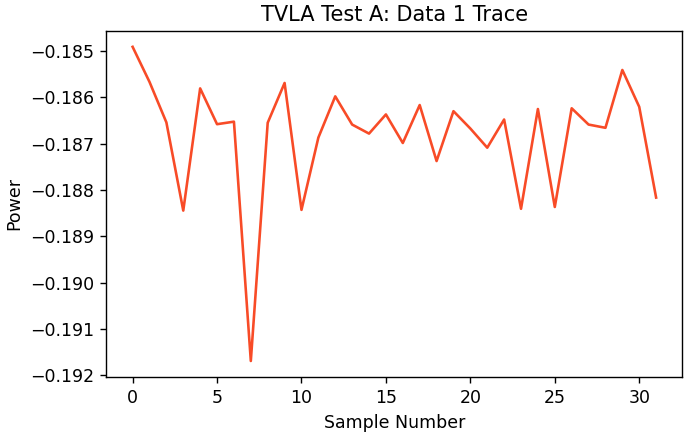

In [288]:
# plot traces using pyplot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# plots the data
plt.plot(d1ta_avg, color="#F84B27")

# format your plots
plt.title("TVLA Test A: Data 1 Trace")  # adds title
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label

# saves the plot
plt.savefig("../Figures/d1ta_A.pdf")
plt.savefig("../Figures/d1ta_A.png", dpi=500)

# show the plot on your screen
plt.show()

### Data 2 Trace

Repeat with a second data:

For each of the 32 iterations, send the same second test data each time to `tvla_test_A`, and append this to a list. Convert the trace list to numpy arrays. Average (sample-wise) the traces, and plot them using pyplot. Compute and report the mean and standard deviation for this average trace.

In [289]:
## get list of test data
test_a2 = random_prod_list()
print("Random values generated are",test_a2)

# initialize variables
d2ta_all = []
d2ta_avg = []
avg = 0
i = 0

# for each of the 32 iterations, send the same first test data to tvla_test_A
# append this to a list
for i in range(32):
    d2ta_all.append(get_pwr_trace(test_a2, 'a'))
    
# convert trace list to numpy array
d2ta = np.array(d2ta_all)

# average the traces (sample-wise)
d2ta_avg =  np.mean(d2ta_all,axis=1)

print("==========================================")
print("Average of the power traces")
print(d2ta_avg)


Random values generated are [209, 230, 147, 100, 17, 76, 212, 121, 63, 28, 146, 210, 175, 31, 11, 39]
Average of the power traces
[-0.18696875 -0.18889063 -0.18664844 -0.18703906 -0.187125   -0.18701562
 -0.18696094 -0.18679688 -0.18714844 -0.18671875 -0.18664063 -0.18685937
 -0.18711719 -0.18580469 -0.18644531 -0.18675781 -0.18707813 -0.18903906
 -0.18713281 -0.18717187 -0.1875     -0.18707031 -0.18690625 -0.18650781
 -0.18695312 -0.18666406 -0.18675781 -0.18780469 -0.18701562 -0.18860156
 -0.18844531 -0.18850781]


<IPython.core.display.Javascript object>


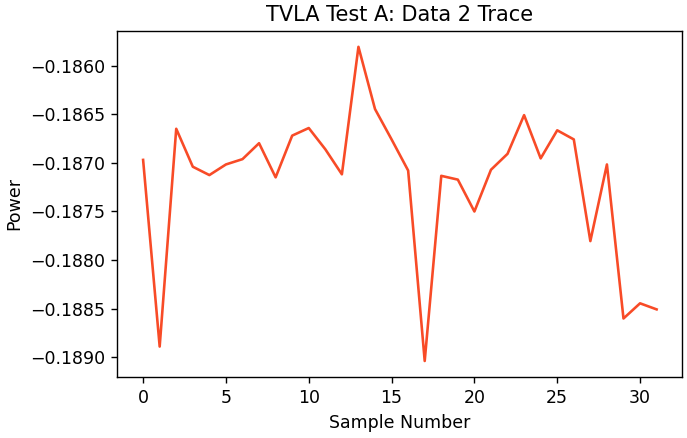

In [290]:
# plot traces using pyplot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# plots the data
plt.plot(d2ta_avg, color="#F84B27")

# format your plots
plt.title("TVLA Test A: Data 2 Trace")  # adds title
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/d2ta_A.pdf")
plt.savefig("../Figures/d2ta_A.png", dpi=500)

# show the plot on your screen
plt.show()

### Differential Trace

Subtract the two traces (from Data 1 and Data 2) to generate a differential trace; plot this separately. Compute and report the mean and standard deviation for this differential trace.

In [291]:
diff_tr_a=d1ta_avg-d2ta_avg

print("Differetial power traces of a")
print(diff_tr_a)

Differetial power traces of a
[ 2.0625000e-03  3.2265625e-03  1.0937500e-04 -1.4062500e-03
  1.3203125e-03  4.3750000e-04  4.3750000e-04 -4.8984375e-03
  6.0156250e-04  1.0312500e-03 -1.7890625e-03 -7.8125000e-06
  1.1406250e-03 -7.8125000e-04 -3.3593750e-04  3.9062500e-04
  9.3750000e-05  2.8750000e-03 -2.4218750e-04  8.7500000e-04
  8.2812500e-04 -1.5625000e-05  4.2968750e-04 -1.8984375e-03
  7.0312500e-04 -1.7031250e-03  5.2343750e-04  1.2187500e-03
  3.5937500e-04  3.1953125e-03  2.2421875e-03  3.4375000e-04]


<IPython.core.display.Javascript object>


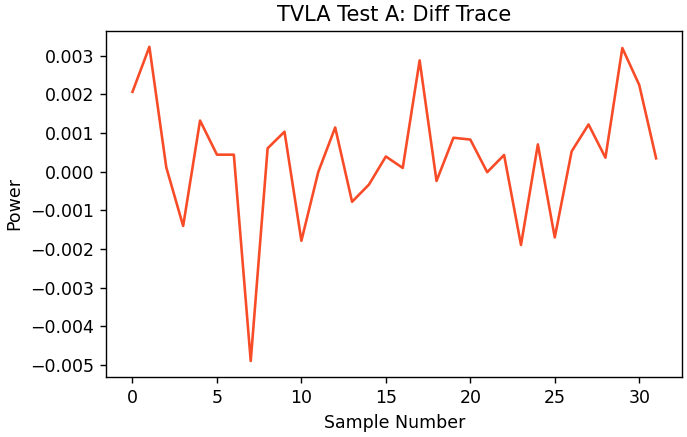

In [292]:
# plot traces using pyplot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# plots the data
plt.plot(diff_tr_a, color="#F84B27")

# format your plots
plt.title("TVLA Test A: Diff Trace")  # adds title
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/diff_tr_A.pdf")
plt.savefig("../Figures/diff_tr_A.png", dpi=500)

# show the plot on your screen
plt.show()

## tvla_test_B

Repeat for `tvla_test_B`.

### Data 1 Trace

For each of the 32 iterations, send the same first test data each time to `tvla_test_B`, and append this to a list. Convert the trace list to numpy arrays. Average (sample-wise) the traces, and plot them using pyplot. Compute and report the mean and standard deviation for this average trace.

In [293]:
# get list of test data
test_b1 = random_prod_list()
print("Random values generated are",test_b1)

print(test_b1)
# initialize variables
d1tb_all = []
d1tb_avg = []

# for each of the 32 iterations, send the same first test data to tvla_test_A
# append this to a list
for i in range(32):
    d1tb_all.append(get_pwr_trace(test_b1, 'b'))
    
    
# convert trace list to numpy array
d1tb_all=np.array(d1tb_all)

# average the traces (sample-wise)
d1tb_avg =  np.mean(d1tb_all,axis=1)

print("==========================================")
print("Average of the power traces")
print(d1tb_avg)

Random values generated are [48, 248, 222, 5, 208, 139, 79, 103, 108, 174, 233, 212, 70, 186, 221, 207]
[48, 248, 222, 5, 208, 139, 79, 103, 108, 174, 233, 212, 70, 186, 221, 207]
Average of the power traces
[-0.17839844 -0.17945312 -0.17773438 -0.17751563 -0.17714844 -0.17814062
 -0.17825    -0.17753906 -0.1775625  -0.17732813 -0.17782031 -0.17960156
 -0.17825    -0.17784375 -0.17739062 -0.17767188 -0.17800781 -0.17708594
 -0.17696875 -0.17928906 -0.17841406 -0.1769375  -0.1776875  -0.17938281
 -0.17776563 -0.17769531 -0.17800781 -0.17748437 -0.17784375 -0.17696875
 -0.17772656 -0.17758594]


<IPython.core.display.Javascript object>


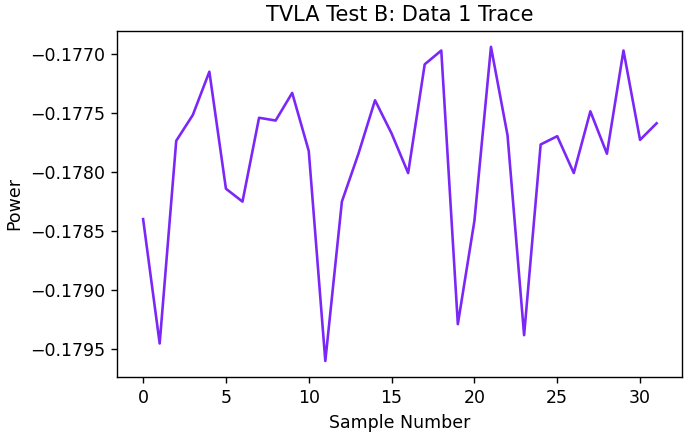

In [294]:
# plot traces using pyplot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# plots the data
plt.plot(d1tb_avg, color="#7A27F8")

# format your plots
plt.title("TVLA Test B: Data 1 Trace")  # adds title
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/d1tb_B.pdf")
plt.savefig("../Figures/d1tb_B.png", dpi=500)

# show the plot on your screen
plt.show()

### Data 2 Trace

Repeat with a second data:

For each of the 32 iterations, send the same second test data each time to `tvla_test_B`, and append this to a list. Convert the trace list to numpy arrays. Average (sample-wise) the traces, and plot them using pyplot. Compute and report the mean and standard deviation for this average trace.

In [295]:
## get list of test data
test_b2 = random_prod_list()
print("Random values generated are",test_b2)

# initialize variables
d2tb_all = []
d2tb_avg = []
avg = 0
i = 0

# for each of the 32 iterations, send the same first test data to tvla_test_A
# append this to a list
for i in range(32):
    d2tb_all.append(get_pwr_trace(test_b2, 'b'))
    
# convert trace list to numpy array
d2tb = np.array(d2tb_all)

# average the traces (sample-wise)
d2tb_avg =  np.mean(d2tb_all,axis=1)

print("==========================================")
print("Average of the power traces")
print(d2tb_avg)

Random values generated are [115, 66, 177, 67, 111, 83, 127, 184, 130, 191, 3, 8, 245, 106, 240, 184]
Average of the power traces
[-0.17655469 -0.17914062 -0.17816406 -0.17795312 -0.17769531 -0.17724219
 -0.17711719 -0.17760938 -0.17702344 -0.17692188 -0.17948438 -0.17841406
 -0.1775625  -0.17772656 -0.1773125  -0.17760938 -0.17725    -0.17664844
 -0.17689062 -0.17770312 -0.17777344 -0.17938281 -0.17835156 -0.1775
 -0.17719531 -0.17703125 -0.17677344 -0.179375   -0.17821875 -0.1776875
 -0.17925    -0.17749219]


<IPython.core.display.Javascript object>


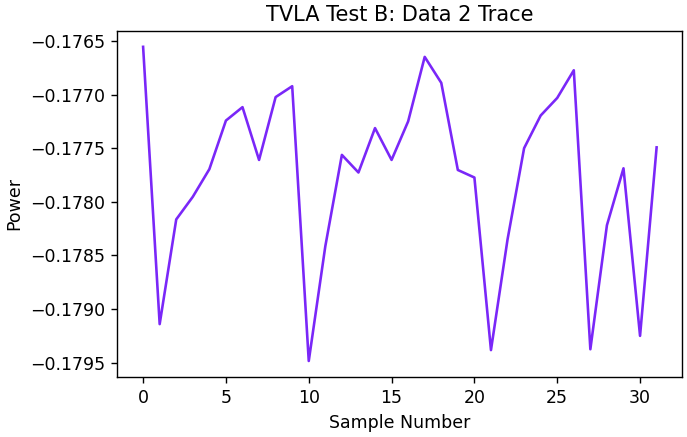

In [296]:
# plot traces using pyplot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# plots the data
plt.plot(d2tb_avg, color="#7A27F8")

# format your plots
plt.title("TVLA Test B: Data 2 Trace")  # adds title
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/d2tb_B.pdf")
plt.savefig("../Figures/d2tb_B.png", dpi=500)

# show the plot on your screen
plt.show()

### Differential Trace

Subtract the two traces (from Data 1 and Data 2) to generate a differential trace; plot this separately. Compute and report the mean and standard deviation for this differential trace.

In [297]:
diff_tr_b=d1tb_avg-d2tb_avg

print("Differetial power traces of b")
print(diff_tr_b)

Differetial power traces of b
[-1.8437500e-03 -3.1250000e-04  4.2968750e-04  4.3750000e-04
  5.4687500e-04 -8.9843750e-04 -1.1328125e-03  7.0312500e-05
 -5.3906250e-04 -4.0625000e-04  1.6640625e-03 -1.1875000e-03
 -6.8750000e-04 -1.1718750e-04 -7.8125000e-05 -6.2500000e-05
 -7.5781250e-04 -4.3750000e-04 -7.8125000e-05 -1.5859375e-03
 -6.4062500e-04  2.4453125e-03  6.6406250e-04 -1.8828125e-03
 -5.7031250e-04 -6.6406250e-04 -1.2343750e-03  1.8906250e-03
  3.7500000e-04  7.1875000e-04  1.5234375e-03 -9.3750000e-05]


<IPython.core.display.Javascript object>


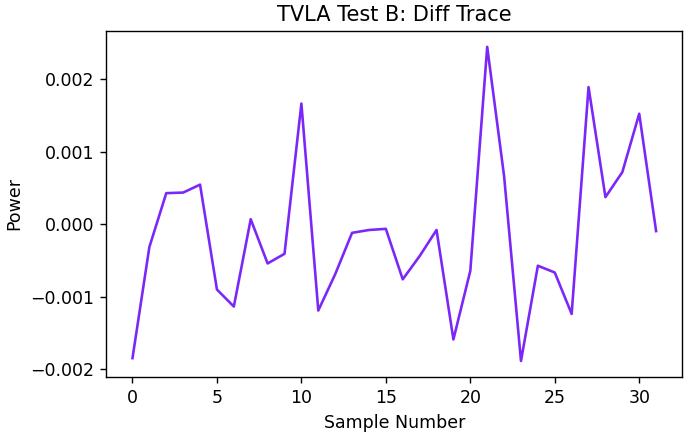

In [298]:
# plot traces using pyplot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# plots the data
plt.plot(diff_tr_b, color="#7A27F8")

# format your plots
plt.title("TVLA Test B: Diff Trace")  # adds title
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/diff_tr_B.pdf")
plt.savefig("../Figures/diff_tr_B.png", dpi=500)

# show the plot on your screen
plt.show()

## tvla_test_C (graduate students only)

Repeat for `tvla_test_C`.

### Data 1 Trace

For each of the 32 iterations, send the same first test data each time to `tvla_test_C`, and append this to a list. Convert the trace list to numpy arrays. Average (sample-wise) the traces, and plot them using pyplot. Compute and report the mean and standard deviation for this average trace.

In [299]:
# get list of test data
test_c1 = random_prod_list()
print("Random values generated are",test_c1)

print(test_b1)
# initialize variables
d1tc_all = []
d1tc_avg = []

# for each of the 32 iterations, send the same first test data to tvla_test_A
# append this to a list
for i in range(32):
    d1tc_all.append(get_pwr_trace(test_c1, 'c'))
    
    
# convert trace list to numpy array
d1tb_all=np.array(d1tc_all)

# average the traces (sample-wise)
d1tc_avg =  np.mean(d1tc_all,axis=1)

print("==========================================")
print("Average of the power traces")
print(d1tc_avg)

Random values generated are [109, 212, 131, 195, 11, 250, 243, 169, 113, 248, 54, 147, 100, 113, 53, 255]
[48, 248, 222, 5, 208, 139, 79, 103, 108, 174, 233, 212, 70, 186, 221, 207]
Average of the power traces
[-0.16545313 -0.16459375 -0.16519531 -0.16539063 -0.16485938 -0.16554688
 -0.16558594 -0.1648125  -0.1649375  -0.16520313 -0.16426562 -0.16521875
 -0.16471094 -0.16421094 -0.16671875 -0.16489063 -0.16489063 -0.16652344
 -0.16473437 -0.16661719 -0.16633594 -0.16513281 -0.16549219 -0.16404688
 -0.1664375  -0.16552344 -0.16482031 -0.16478906 -0.16642187 -0.16510938
 -0.166375   -0.1645625 ]


<IPython.core.display.Javascript object>


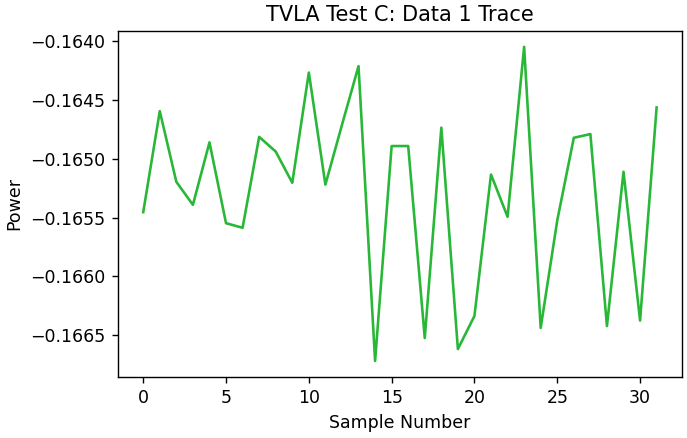

In [300]:
# plot traces using pyplot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# plots the data
plt.plot(d1tc_avg, color="#28B737")

# format your plots
plt.title("TVLA Test C: Data 1 Trace")  # adds title
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/d1tc_C.pdf")
plt.savefig("../Figures/d1tc_C.png", dpi=500)

# show the plot on your screen
plt.show()

### Data 2 Trace

Repeat with a second data:

For each of the 32 iterations, send the same second test data each time to `tvla_test_C`, and append this to a list. Convert the trace list to numpy arrays. Average (sample-wise) the traces, and plot them using pyplot. Compute and report the mean and standard deviation for this average trace.

In [301]:
## get list of test data
test_c2 = random_prod_list()
print("Random values generated are",test_c2)

# initialize variables
d2tc_all = []
d2tc_avg = []
avg = 0
i = 0

# for each of the 32 iterations, send the same first test data to tvla_test_A
# append this to a list
for i in range(32):
    d2tc_all.append(get_pwr_trace(test_c2, 'c'))
    
# convert trace list to numpy array
d2tc = np.array(d2tc_all)

# average the traces (sample-wise)
d2tc_avg =  np.mean(d2tc_all,axis=1)

print("==========================================")
print("Average of the power traces")
print(d2tc_avg)

Random values generated are [249, 160, 172, 227, 159, 94, 63, 194, 40, 52, 209, 107, 255, 58, 113, 231]
Average of the power traces
[-0.1668125  -0.16632812 -0.16707031 -0.16886719 -0.16778906 -0.16675781
 -0.16717187 -0.16740625 -0.167375   -0.16890625 -0.16709375 -0.16889844
 -0.16692187 -0.16684375 -0.166375   -0.168625   -0.16705469 -0.16790625
 -0.16874219 -0.16722656 -0.16660156 -0.1669375  -0.16690625 -0.16653125
 -0.16610938 -0.16867969 -0.16701563 -0.16895313 -0.16796094 -0.16892969
 -0.16788281 -0.16680469]


<IPython.core.display.Javascript object>


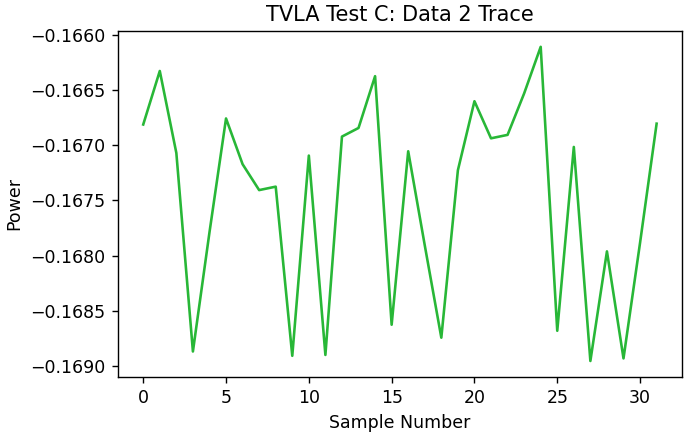

In [302]:
# plot traces using pyplot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# plots the data
plt.plot(d2tc_avg, color="#28B737")

# format your plots
plt.title("TVLA Test C: Data 2 Trace")  # adds title
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/d2tc_C.pdf")
plt.savefig("../Figures/d2tc_C.png", dpi=500)

# show the plot on your screen
plt.show()

### Differential Trace

Subtract the two traces (from Data 1 and Data 2) to generate a differential trace; plot this separately. Compute and report the mean and standard deviation for this differential trace.

In [303]:
diff_tr_c=d1tc_avg-d2tc_avg

print("Differetial power traces of c")
print(diff_tr_c)

Differetial power traces of c
[ 0.00135937  0.00173437  0.001875    0.00347656  0.00292969  0.00121094
  0.00158594  0.00259375  0.0024375   0.00370313  0.00282813  0.00367969
  0.00221094  0.00263281 -0.00034375  0.00373437  0.00216406  0.00138281
  0.00400781  0.00060937  0.00026562  0.00180469  0.00141406  0.00248437
 -0.00032812  0.00315625  0.00219531  0.00416406  0.00153906  0.00382031
  0.00150781  0.00224219]


<IPython.core.display.Javascript object>


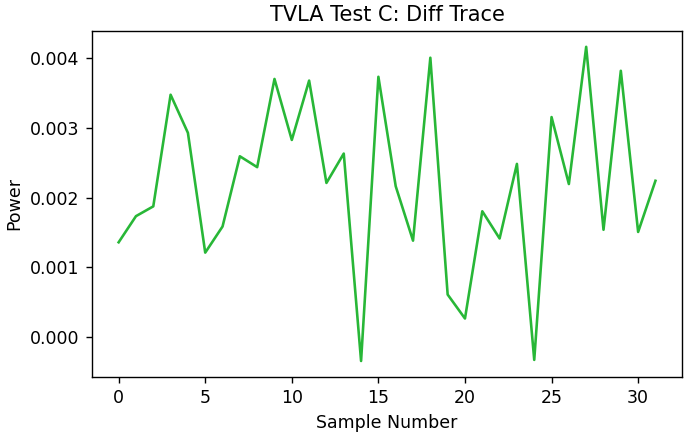

In [304]:
# plot traces using pyplot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# plots the data
plt.plot(diff_tr_c, color="#28B737")

# format your plots
plt.title("TVLA Test C: Diff Trace")  # adds title
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/diff_tr_C.pdf")
plt.savefig("../Figures/diff_tr_C.png", dpi=500)

# show the plot on your screen
plt.show()

## Mean and Standard Deviation

In [305]:
print("===========Mean vlaues for averaged traces==========")
print("Data 1_A Trace:",np.round(np.mean(d1ta_avg),3))
print("Data 2_A Trace:",np.round(np.mean(d2ta_avg),3))
print("Diff_A Trace:",np.round(np.mean(diff_tr_a),3))
print("Data 1_B Trace:",np.round(np.mean(d1tb_avg),3))
print("Data 2_B Trace:",np.round(np.mean(d2tb_avg),3))
print("Diff_B Trace:",np.round(np.mean(diff_tr_b),3))
print("Data 1_C Trace:",np.round(np.mean(d1tc_avg),3))
print("Data 2_C Trace:",np.round(np.mean(d2tc_avg),3))
print("Diff_C Trace:",np.round(np.mean(diff_tr_c),3))
print("====================================================\n")

print("============SD vlaues for averaged traces==========")

print("Data 1_A Trace:",np.round(np.std(d1ta_avg),3))
print("Data 2_A Trace:",np.round(np.std(d2ta_avg),3))
print("Diff_A Trace:",np.round(np.std(diff_tr_a),3))
print("Data 1_B Trace:",np.round(np.std(d1tb_avg),3))
print("Data 2_B Trace:",np.round(np.std(d2tb_avg),3))
print("Diff_B Trace:",np.round(np.std(diff_tr_b),3))
print("Data 1_C Trace:",np.round(np.std(d1tc_avg),3))
print("Data 2_C Trace:",np.round(np.std(d2tc_avg),3))
print("Diff_C Trace:",np.round(np.std(diff_tr_c),3))
print("===================================================")

===========Mean vlaues for averaged traces==========
Data 1_A Trace: -0.187
Data 2_A Trace: -0.187
Diff_A Trace: 0.0
Data 1_B Trace: -0.178
Data 2_B Trace: -0.178
Diff_B Trace: -0.0
Data 1_C Trace: -0.165
Data 2_C Trace: -0.167
Diff_C Trace: 0.002

============SD vlaues for averaged traces==========
Data 1_A Trace: 0.001
Data 2_A Trace: 0.001
Diff_A Trace: 0.002
Data 1_B Trace: 0.001
Data 2_B Trace: 0.001
Diff_B Trace: 0.001
Data 1_C Trace: 0.001
Data 2_C Trace: 0.001
Diff_C Trace: 0.001


# Statistical Analysis

Now that you captured multiple traces, then the next goal is to analyze the traces for any potential information leakage with a statistical hypothesis test (SHT).

Using scipy, perform Welch's t-test for each function (note the optional equal\_var parameter!): https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

Note also that this function returns a pair of values `t` and `p`.

## tvla_test_A

Perform SHT analysis on `tvla_test_A`.

### Welch's t-test for Trace A

Perform the Welch's t-test between the original pair of 32 traces from the `tvla_test_A`. Get the `t` and `p` values.

Note: these are not the sample-wise average power lists.

In [306]:
ttest_a = scipy.stats.ttest_ind(d1ta_all, d2ta_all, equal_var=False)
tval_a = ttest_a[0]
pval_a = ttest_a[1]


### Mean and standard deviation for the `t` values.

Get the mean and standard deviation for the `t` values you just got.

Note: the `t` values list may have `nan` values. Use `np.nanmean` and `np.nanstd` to get the mean and standard deviation values, respectively, while ignoring those `nan` values.

In [307]:
# get mean and standard deviation for t values
tval_a_mean = np.nanmean(tval_a)
tval_a_std = np.nanstd(tval_a)

print("Trace A t-value | Mean:",tval_a_mean.round(4))
print("Trace A t-value | Std:",tval_a_std.round(4))

Trace A t-value | Mean: 0.2206
Trace A t-value | Std: 1.7743


### Plot t-values

Plot the `t` values you just got.

<IPython.core.display.Javascript object>


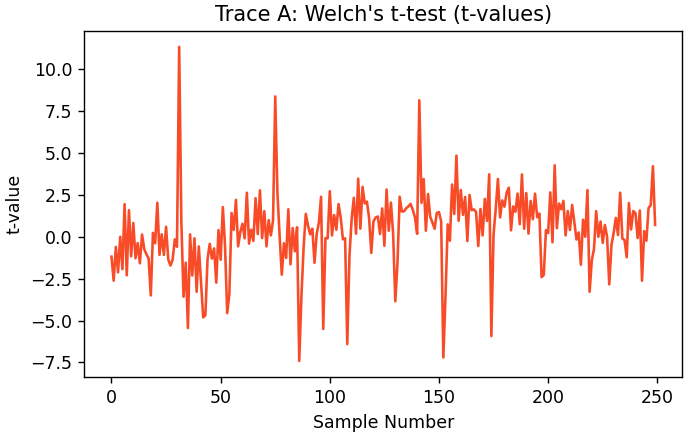

In [308]:
# plot traces using pyplot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# plots the data
plt.plot(tval_a[0:250], color="#F84B27")

# format your plots
plt.title("Trace A: Welch's t-test (t-values)")  # adds title
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("t-value")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/ttesta.pdf")
plt.savefig("../Figures/ttesta.png", dpi=500)

# show the plot on your screen
plt.show()

### Get percentage of statistical significance

Get the percentage of `p`-values you just got which indicate statistical significance at the 5% threshold (i.e. are below 0.05).

In [314]:
count_significant_a = len(pval_a[pval_a <= 0.05])

# Calculate the percentage
percentage_significant_a = (count_significant_a / len(pval_a)) * 100

print("percentage of statistical significance for trace A",round(percentage_significant_a,4))

percentage of statistical significance for trace A 18.2


## tvla_test_B

Perform SHT analysis on `tvla_test_B`.

### Welch's t-test for Trace B

Perform the Welch's t-test between the original pair of 32 traces from the `tvla_test_B`. Get the `t` and `p` values.

Note: these are not the sample-wise average power lists.

In [315]:
ttest_b = scipy.stats.ttest_ind(d1tb_all, d2tb_all, equal_var=False)
tval_b = ttest_b[0]
pval_b = ttest_b[1]

### Mean and standard deviation for the `t` values.

Get the mean and standard deviation for the `t` values you just got.

Note: the `t` values list may have `nan` values. Use `np.nanmean` and `np.nanstd` to get the mean and standard deviation values, respectively, while ignoring those `nan` values.

In [316]:
# get mean and standard deviation for t values
tval_b_mean = np.nanmean(tval_b)
tval_b_std = np.nanstd(tval_b)

print("Trace B t-value | Mean:",tval_b_mean.round(4))
print("Trace B t-value | Std:",tval_b_std.round(4))

Trace B t-value | Mean: 8.6915
Trace B t-value | Std: 84.1513


### Plot t-values

Plot the `t` values you just got.

<IPython.core.display.Javascript object>


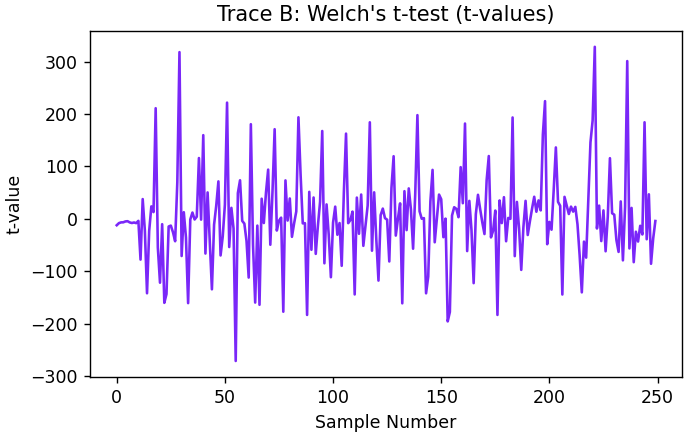

In [317]:
# plot traces using pyplot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# plots the data
plt.plot(tval_b[0:250], color="#7A27F8")

# format your plots
plt.title("Trace B: Welch's t-test (t-values)")  # adds title
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("t-value")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/ttestb.pdf")
plt.savefig("../Figures/ttestb.png", dpi=500)

# show the plot on your screen
plt.show()

### Get percentage of statistical significance

Get the percentage of `p`-values you just got which indicate statistical significance at the 5% threshold (i.e. are below 0.05).

In [318]:
count_significant_b = len(pval_b[pval_b <= 0.05])

# Calculate the percentage
percentage_significant_b = (count_significant_b / len(pval_b)) * 100

print("percentage of statistical significance for trace B",round(percentage_significant_b,4))

percentage of statistical significance for trace B 96.4


## tvla_test_C (graduate students only)

Perform SHT analysis on `tvla_test_C`.

### Welch's t-test for Trace C

Perform the Welch's t-test between the original pair of 32 traces from the `tvla_test_C`. Get the `t` and `p` values.

Note: these are not the sample-wise average power lists.

In [319]:
ttest_c = scipy.stats.ttest_ind(d1tc_all, d2tc_all, equal_var=False)
tval_c = ttest_c[0]
pval_c = ttest_c[1]


print(tval_c, "\n")
print(pval_c)

[-5.42410971e+00 -2.66493206e+00 -1.21524301e+00  5.48608124e-01
  1.16758634e+00  4.79987613e-01 -5.55850789e-01 -2.27394004e+00
 -1.61623321e+00 -7.35054427e-01  2.07067385e-01  3.37848886e+00
  2.04351689e+00  4.57729271e-01 -1.58999682e+00 -2.03839407e+00
 -3.38832151e+00 -2.82421163e+00  5.62370581e-01  2.15101503e+00
 -3.48325601e-01 -1.38828239e+00  1.55627952e+00  3.29934552e-01
 -1.52958251e+00  8.17596240e-01  3.06071042e+00  2.01084019e+00
  1.06649038e+00 -1.09634142e+00 -1.58858997e+00 -4.23289867e+00
 -1.98303132e+00  4.15321230e+00  1.73004227e+00  1.11646344e+00
 -8.08921233e-01 -2.22993848e+00 -2.15140962e+00 -1.27133523e+00
  5.81357879e-01  2.67368945e+00  2.04720821e+00  9.36272761e-01
 -1.41675483e+00 -1.74619023e+00 -4.16829209e+00 -5.47957086e-01
  1.86527124e-01  2.35144373e+00  1.95949382e+00  1.53930782e+00
  0.00000000e+00 -2.02557181e+00 -2.98368249e+00  7.34580994e-01
  2.65094291e+00  2.87332457e+00  1.81216165e+00  0.00000000e+00
 -1.59306726e+00 -2.48077

### Mean and standard deviation for the `t` values.

Get the mean and standard deviation for the `t` values you just got.

Note: the `t` values list may have `nan` values. Use `np.nanmean` and `np.nanstd` to get the mean and standard deviation values, respectively, while ignoring those `nan` values.

In [320]:
# get mean and standard deviation for t values
tval_c_mean = np.nanmean(tval_c)
tval_c_std = np.nanstd(tval_c)

print("Trace C t-value | Mean:",tval_c_mean.round(4))
print("Trace C t-value | Std:",tval_c_std.round(4))

Trace C t-value | Mean: 1.5025
Trace C t-value | Std: 46.711


### Plot t-values

Plot the `t` values you just got.

<IPython.core.display.Javascript object>


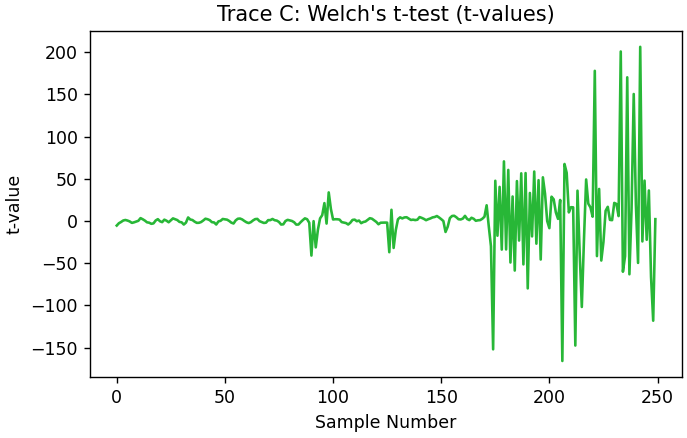

In [321]:
# plot traces using pyplot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# plots the data
plt.plot(tval_c[0:250], color="#28B737")

# format your plots
plt.title("Trace C: Welch's t-test (t-values)")  # adds title
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("t-value")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/ttestc.pdf")
plt.savefig("../Figures/ttestc.png", dpi=500)

# show the plot on your screen
plt.show()

### Get percentage of statistical significance

Get the percentage of `p`-values you just got which indicate statistical significance at the 5% threshold (i.e. are below 0.05).

In [323]:
count_significant_c = len(pval_c[pval_c <=0.05])

# Calculate the percentage
percentage_significant_c = (count_significant_c / len(pval_c)) * 100

print("percentage of statistical significance for trace C",round(percentage_significant_c,4))

percentage of statistical significance for trace C 80.0


# Diconnect Scope/Target

Disconnect the CW's scope and target:

In [324]:
scope.dis()
target.dis()